# hydronetworks

In [34]:
# Import necessary modules

import geopandas as gpd
import pyproj
from pathlib import Path
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
%matplotlib inline

## 1. Specify file paths

In [2]:
in_path = Path('test_data')
out_path = Path('test_output')

admin_path = in_path / "pastaza.gpkg"
rivers_path = in_path / 'HydroRIVERS_10v.gpkg'
dem_path = in_path / 'cond_dem.tif'
flow_path = in_path / 'qmean.tif'
flowacc_path = in_path / 'accflow.tif'

#### Define init coordinate system for gpkg (if missing)

In [3]:
# Importing admin layer as geodf
admin_gdf = gpd.read_file(admin_path , layer='pastaza')
river_gdf = gpd.read_file(rivers_path , layer='HydroRIVERS_10v')

In [4]:
# Reproject data in to Ordnance Survey GB coordinates
admin_gdf_proj = admin_gdf.to_crs({'init': 'epsg:24877'})

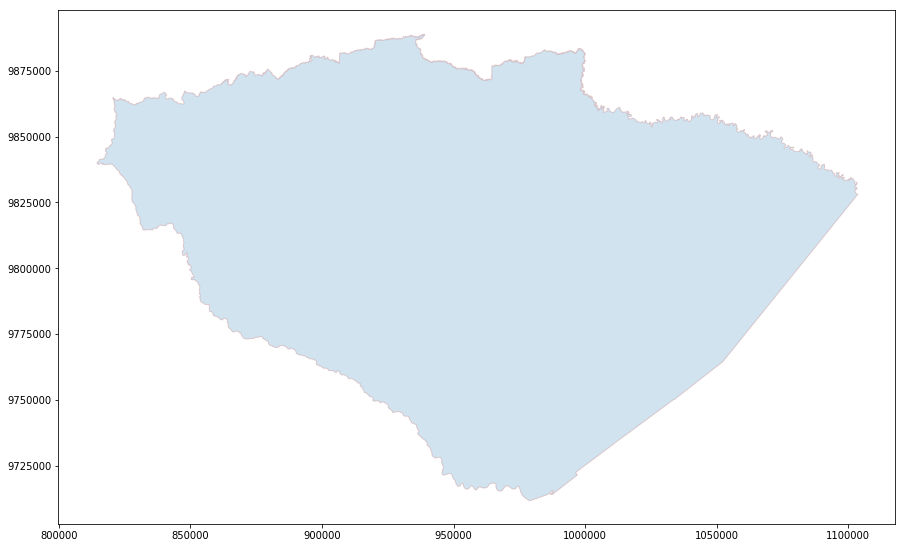

In [5]:
# Plot the data
fig, ax = plt.subplots(figsize=(15, 15))
admin_gdf_proj.plot(ax=ax, edgecolor='brown', alpha=0.2)
ax.set_aspect('equal', 'box')

# Save plot as figure 
#plt.savefig('Maize_Harv_Area_2017.png', bbox_inches='tight')

In [6]:
# Reproject data in to Ordnance Survey GB coordinates
river_gdf_proj = river_gdf.to_crs({'init': 'epsg:24877'})

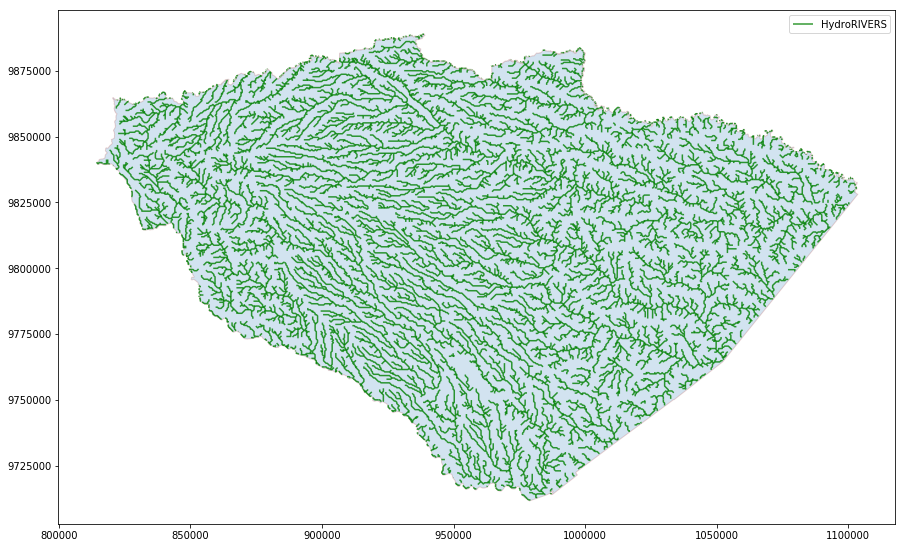

In [8]:
fig, ax = plt.subplots(figsize=(15, 15))
admin_gdf_proj.plot(ax=ax, edgecolor='brown', alpha=0.2)
river_gdf_proj.plot(ax=ax, color='green', edgecolor='none', figsize=(20, 20), alpha=0.8, label='HydroRIVERS')
ax.set_aspect('equal', 'box')
leg = ax.legend()
 
# Save plot as figure 
#plt.savefig('xxx.png', bbox_inches='tight')

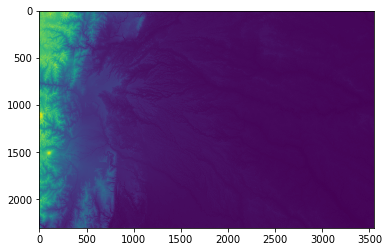

In [9]:
src = rasterio.open(dem_path)
plt.imshow(src.read(1), cmap='viridis')

In [13]:
from hydronetworks import HydroNetworks

In [14]:
sel_proj = 'epsg:24877'   # PSAD56 / UTM zone 17S for Ecuador
sel_proj

'epsg:24877'

## 2. Read in all the necessary files
And do some quick sanity checks

In [16]:
net = HydroNetworks(rivers_path=rivers_path,
                    dem_path=dem_path,
                    flow_path=flow_path,
                    flowacc_path=flowacc_path,
                    sel_proj=sel_proj)

In [17]:
net.sel_proj

'epsg:24877'

In [18]:
net.load_files()

Global Streamflow dataset


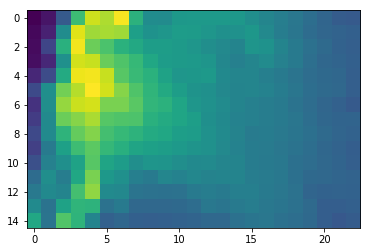

In [19]:
print('Global Streamflow dataset')
plt.imshow(net.flow.read(1))
plt.show()

DEM


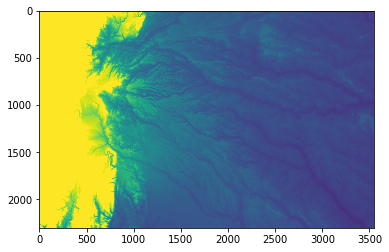

In [20]:
print('DEM')
plt.imshow(net.dem.read(1), vmin=0, vmax=1000)
plt.show()

Rivers with 6935 segments


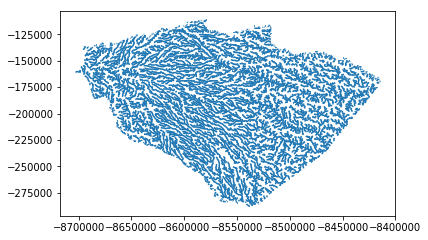

In [21]:
print('Rivers with', len(net.rivers), 'segments')
net.rivers.plot()
plt.show()

## 2. Process network and attributes
These will be the main data structures for holding the river network, and the nodes where rivers join

In [22]:
net.create_network()

Created network and nodes


Then calculate Shreve stream order for the network
This allows to easily keep track of what is upstream and downstream

In [42]:
net.network[1]

array([       1, -8579143,  -112302, -8579453,  -111469,        2,
              3,      -99,     1269])

In [43]:
df_test = pd.DataFrame({'col':net.nodes})

In [41]:
df_test.head(15)

,col
0,"[0, -8580645, -112192, {}, 0]"
1,"[1, -8580630, -112177, {}, 0]"
2,"[2, -8579143, -112302, {}, 1]"
3,"[3, -8579453, -111469, {}, 1]"
4,"[4, -8591028, -112653, {}, 2]"
5,"[5, -8590849, -112653, {}]"
6,"[6, -8590849, -112445, {}, 3]"
7,"[7, -8590849, -112653, {}]"
8,"[8, -8590849, -112653, {}, 2, 3, 4]"
9,"[9, -8590633, -112653, {}, 4]"


In [8]:
net.assign_streamorder()

Stream ordered


And import elevation, gscd etc for each node

In [9]:
net.load_attributes()

Attributes loaded


Convert to GeoDataFrames

In [10]:
net.network_to_gdf()

Converted!


## 3. Calculate local flow and hydro potential

In [11]:
net.local_flowacc()
net.calculate_hydro()

Calculated hydro potential


## 4. Sanity check and save

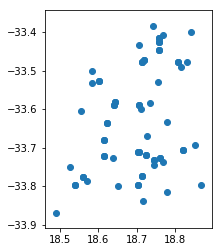

In [12]:
net.nodes_out.plot()

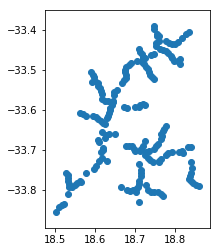

In [13]:
net.hydro_points.plot()

In [14]:
net.save_results(out_path)